# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score

import random

from xgboost import XGBRanker

# Set random seed

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [3]:
seed = 1234
set_seed(seed)

# Prepare data

## Load dataset

In [4]:
# https://drive.google.com/file/d/1viFKqtYTtTiP9_EdBXVpCmWbNmxDiXWG/view

dataset_path = 'data/intern_task.csv'
df = pd.read_csv(dataset_path)

In [5]:
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


1. **query_id** - An identifier for the search session that groups all documents (objects) related to a specific search query.

2. **feature_0** to **feature_143** - Anonymized features characterizing the relevance of a document in relation to the search query.

3. **rank** - The target variable indicating the relevance score of each document, where a lower rank value suggests higher relevance of the document to the query.

---

1. **query_id** - Идентификатор поисковой сессии, который группирует все документы (объекты), связанные с определённым поисковым запросом. 

2. **feature_0** до **feature_143** - Обезличенные признаки, характеризующие релевантность документа по отношению к поисковому запросу. 

3. **rank** - Целевая переменная - оценка релевантности каждого документа, где более низкое значение rank указывает на более высокую релевантность документа к запросу. 

In [6]:
print(f'Dataset size: {df.shape[0]} rows, {df.shape[1]} columns')

Dataset size: 235258 rows, 146 columns


In [7]:
pd.set_option('display.max_rows', 200)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rank,235258.0,6.778686e-01,8.300334e-01,0.000000,0.000000,0.000000,1.000000e+00,4.000000e+00
query_id,235258.0,1.482841e+04,8.193945e+03,10.000000,8215.000000,14935.000000,2.158000e+04,2.999500e+04
feature_0,235258.0,1.911960e+00,1.237374e+00,0.000000,1.000000,2.000000,3.000000e+00,3.100000e+01
feature_1,235258.0,2.062332e-01,5.790888e-01,0.000000,0.000000,0.000000,0.000000e+00,1.800000e+01
feature_2,235258.0,1.189847e+00,1.037233e+00,0.000000,0.000000,1.000000,2.000000e+00,2.700000e+01
feature_3,235258.0,5.502725e-01,7.909465e-01,0.000000,0.000000,0.000000,1.000000e+00,9.000000e+00
feature_4,235258.0,1.960082e+00,1.203534e+00,0.000000,1.000000,2.000000,3.000000e+00,3.100000e+01
feature_5,235258.0,8.039641e-01,3.399551e-01,0.000000,0.666667,1.000000,1.000000e+00,1.000000e+00
feature_6,235258.0,9.755747e-02,2.660348e-01,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
feature_7,235258.0,5.411739e-01,4.199727e-01,0.000000,0.000000,0.500000,1.000000e+00,1.000000e+00


In [9]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235258 entries, 0 to 235257
Data columns (total 146 columns):
 #    Column       Non-Null Count   Dtype  
---   ------       --------------   -----  
 0    rank         235258 non-null  int64  
 1    query_id     235258 non-null  int64  
 2    feature_0    235258 non-null  float64
 3    feature_1    235258 non-null  float64
 4    feature_2    235258 non-null  float64
 5    feature_3    235258 non-null  float64
 6    feature_4    235258 non-null  float64
 7    feature_5    235258 non-null  float64
 8    feature_6    235258 non-null  float64
 9    feature_7    235258 non-null  float64
 10   feature_8    235258 non-null  float64
 11   feature_9    235258 non-null  float64
 12   feature_10   235258 non-null  float64
 13   feature_11   235258 non-null  float64
 14   feature_12   235258 non-null  float64
 15   feature_13   235258 non-null  float64
 16   feature_14   235258 non-null  float64
 17   feature_15   235258 non-null  float64
 18   fe

Most features (140) have the `float64` data type, while the remaining (6) have `int64`.

Большинство признаков (140) имеют тип `float64`, остальные (6) - `int64`.

In [10]:
df.isna().sum().sum()

0

The dataset does not contain any missing values or `NaN`.

Набор данных не содержит пропущенных значений и `NaN`.





In [11]:
print(df[df.duplicated].shape[0])

0


The dataset does not contain any duplicate rows.

Набор данных не содержит дублирующихся строк.

In [12]:
df['rank'].value_counts()

rank
0    121521
1     75815
2     31910
3      4209
4      1803
Name: count, dtype: int64

The relevance score `rank` takes values 0, 1, 2, 3, 4.

Оценка релевантности `rank` принимает значения 0, 1, 2, 3, 4.




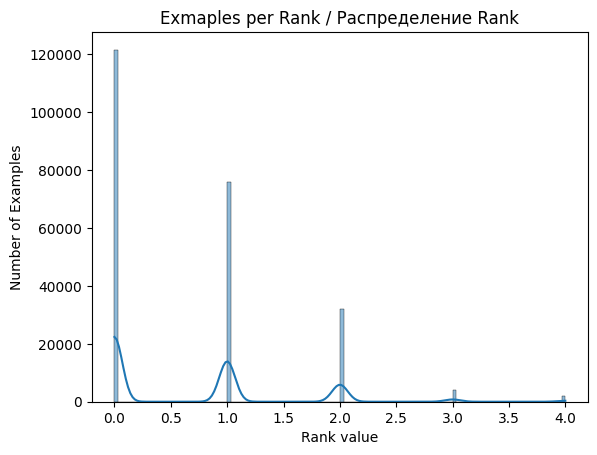

In [13]:
sns.histplot(data=df, x="rank", kde=True)

# Настройка заголовка и меток осей
plt.title("Exmaples per Rank / Распределение Rank")
plt.xlabel("Rank value")
plt.ylabel("Number of Examples")

plt.show()

In [14]:
df.query_id.value_counts()

query_id
22540    908
13930    773
22450    522
19945    444
9940     430
        ... 
22780      2
14350      2
9265       1
20560      1
28285      1
Name: count, Length: 2000, dtype: int64

The dataset contains information about 2000 search sessions. Each session corresponds to between 1 and 908 objects.

В наборе есть информация о 2000 поисковых сессиях. Каждой соответствует от 1 до 908 объектов.

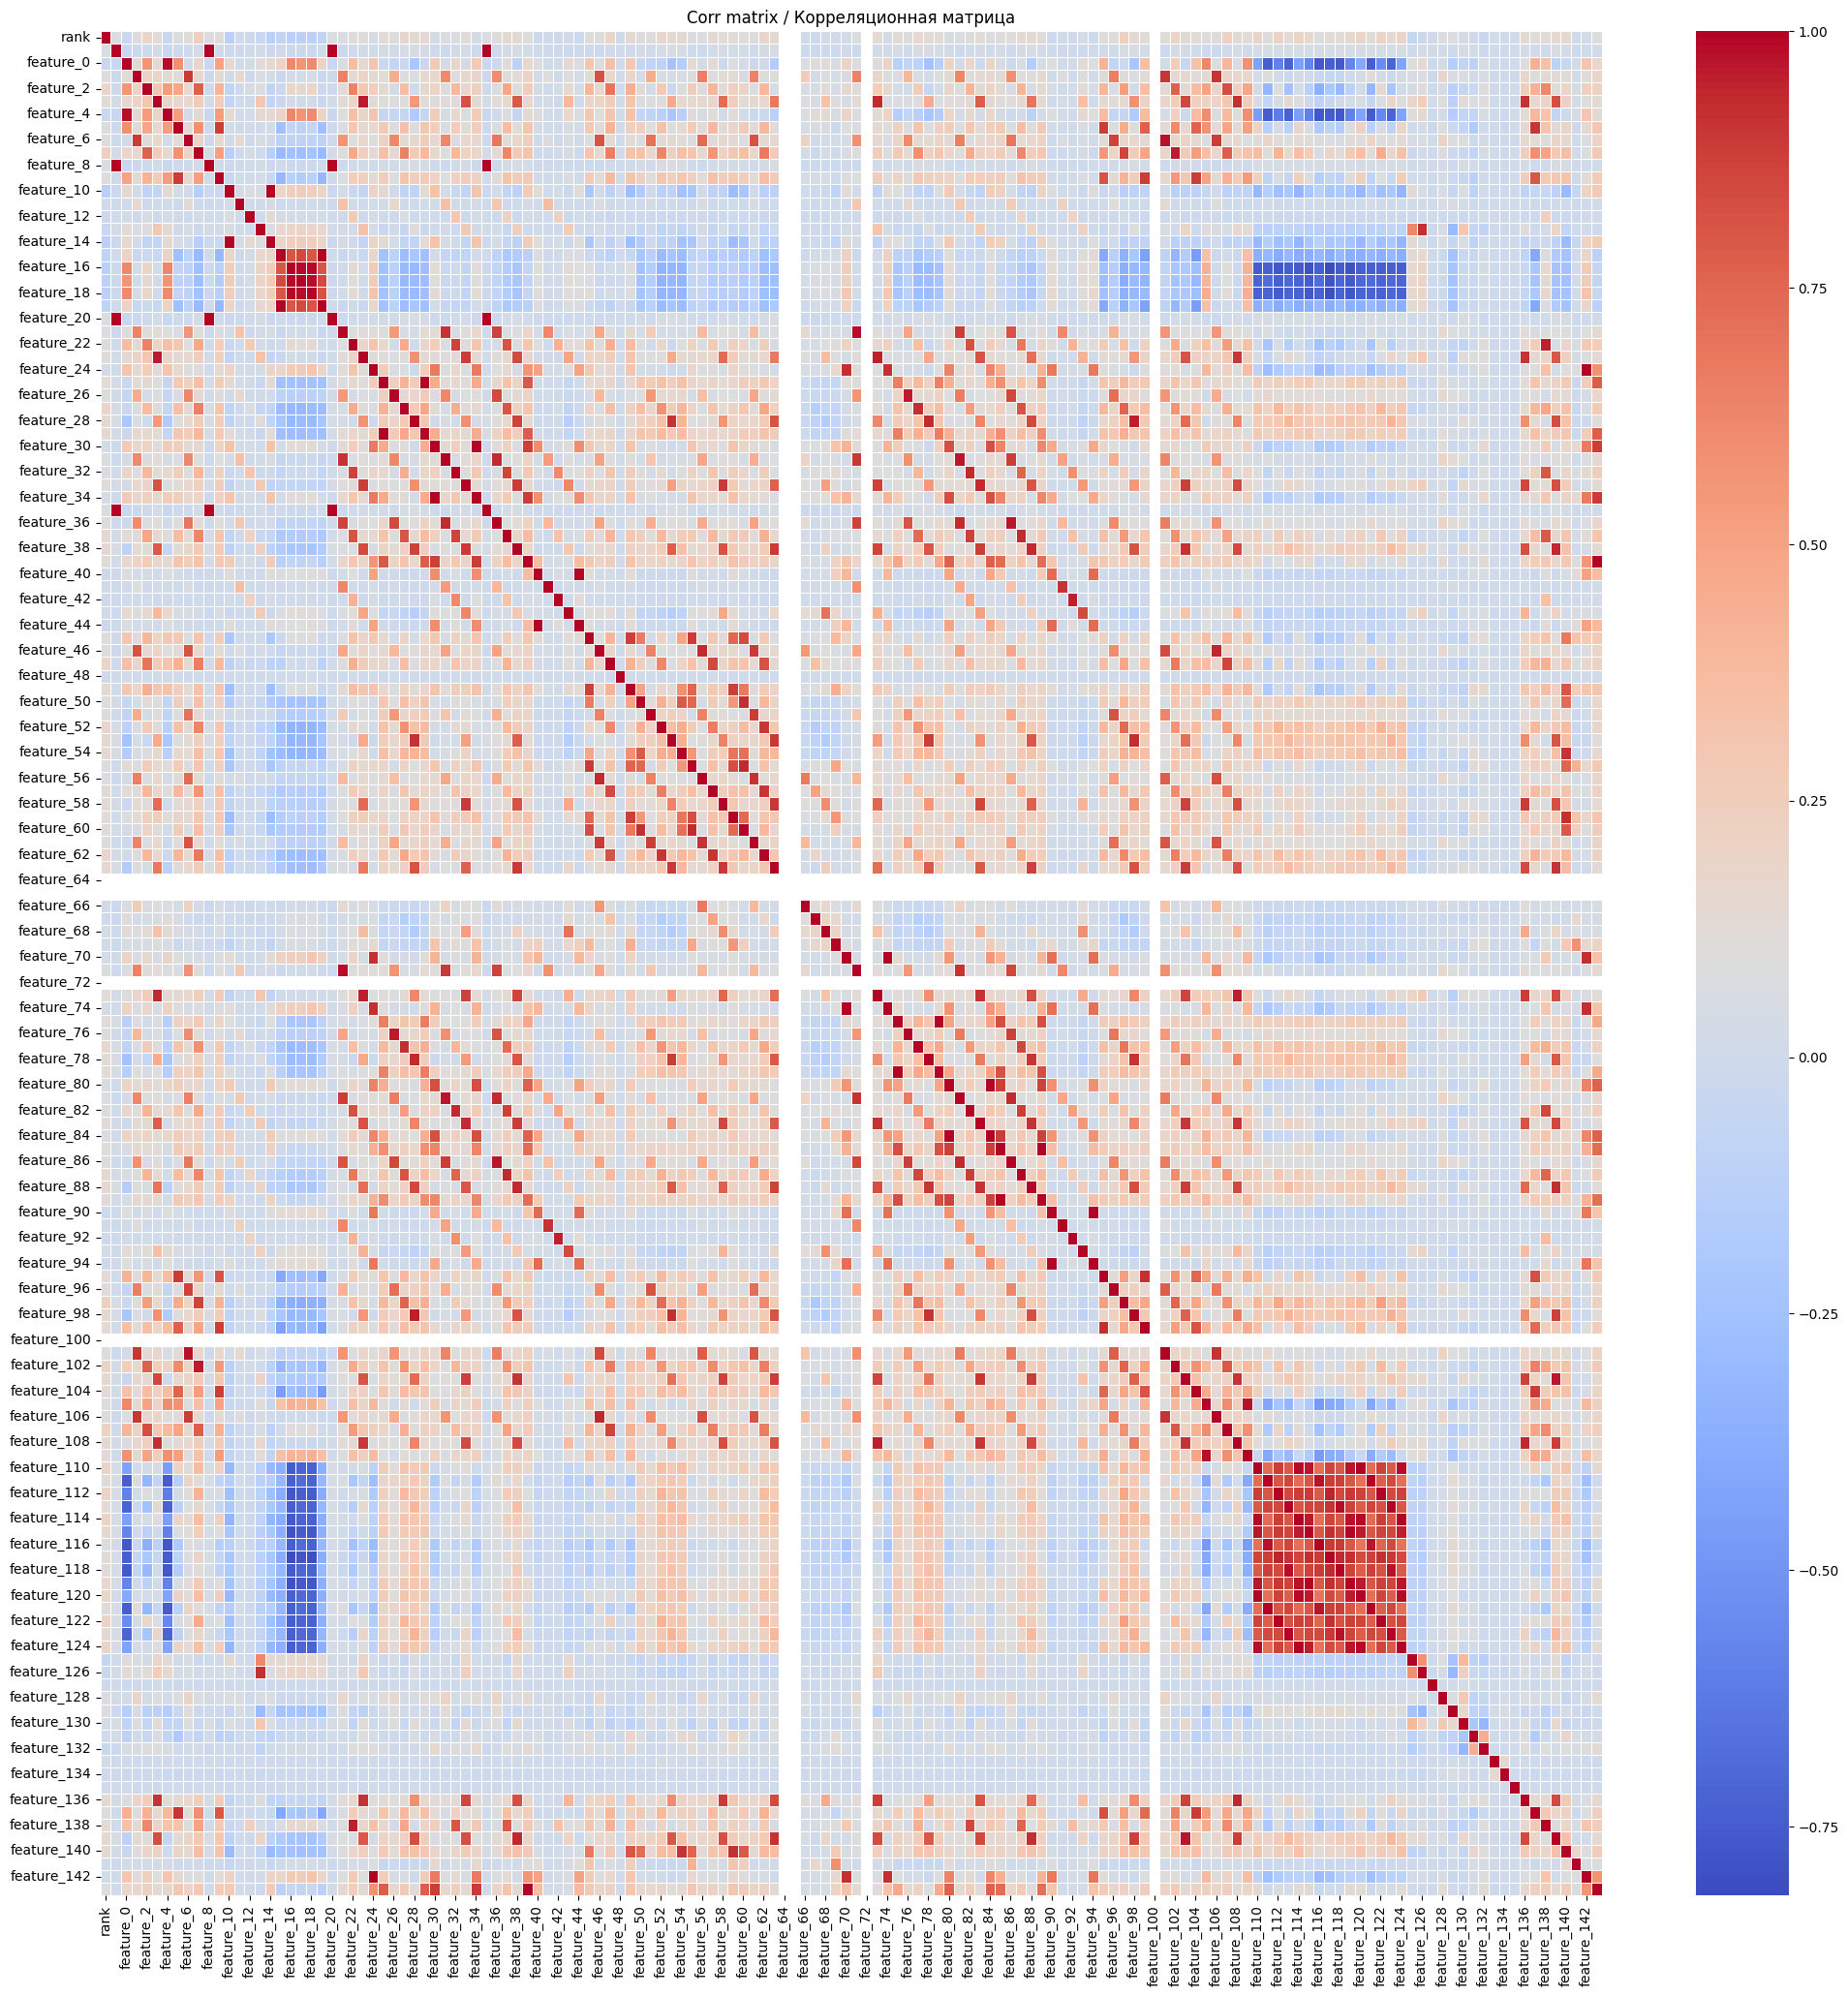

In [15]:
corr_matrix = df.corr()

# Создание тепловой карты
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Corr matrix / Корреляционная матрица')
plt.show()

Some features in the dataset have a significant correlation (>0.5) with others.

Некторые признаки в наборе имеют значительную корреляцию (>0.5) с другими

## Split dataset

In [16]:
df_train, df_tmp = train_test_split(df, test_size=0.3, random_state=seed)
df_val, df_test = train_test_split(df_tmp, test_size=0.5, random_state=seed)

In [17]:
df_train.shape, df_val.shape, df_test.shape

((164680, 146), (35289, 146), (35289, 146))

The dataset was split into 3 subsets - training, validation, and test sets in the ratio of 0.7 : 0.15 : 0.15.

Набор данных был разделен на 3 выборки - обучающую, валидационную и тестовую в соотношении - 0.7 : 0.15 : 0.15

## Correct data

In [18]:
def plot_boxplots(dataframe):
    """
    Plots boxplots for all numerical columns in the given dataframe.

    Args:
        dataframe (pandas.DataFrame): The input dataframe.

    Returns:
        None
    """
    # Get a list of all numerical columns in the dataframe
    num_columns = dataframe.select_dtypes(include=['number']).columns

    # Calculate the number of plots required
    num_plots = len(num_columns)

    # Determine the number of rows needed for the subplots
    rows = (num_plots + 1) // 2

    # Create a figure with the required number of subplots
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20, 100))

    # Iterate over the numerical columns
    for i, column in enumerate(num_columns):
        # Calculate the row and column indices for the current subplot
        row = i // 2
        col = i % 2

        # Get the current subplot axis
        ax = axes[row, col]

        # Plot the boxplot for the current column
        sns.boxplot(x=dataframe[column], ax=ax)

        # Set the title and x-label for the current subplot
        ax.set_title(f"Boxplot of {column}")
        ax.set_xlabel(column)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

Build a boxplot for all numerical features to visualise their distribution and search for outliers

Строим boxplot для всех числовых признаков для визуализации их распределения и поиска выбросов

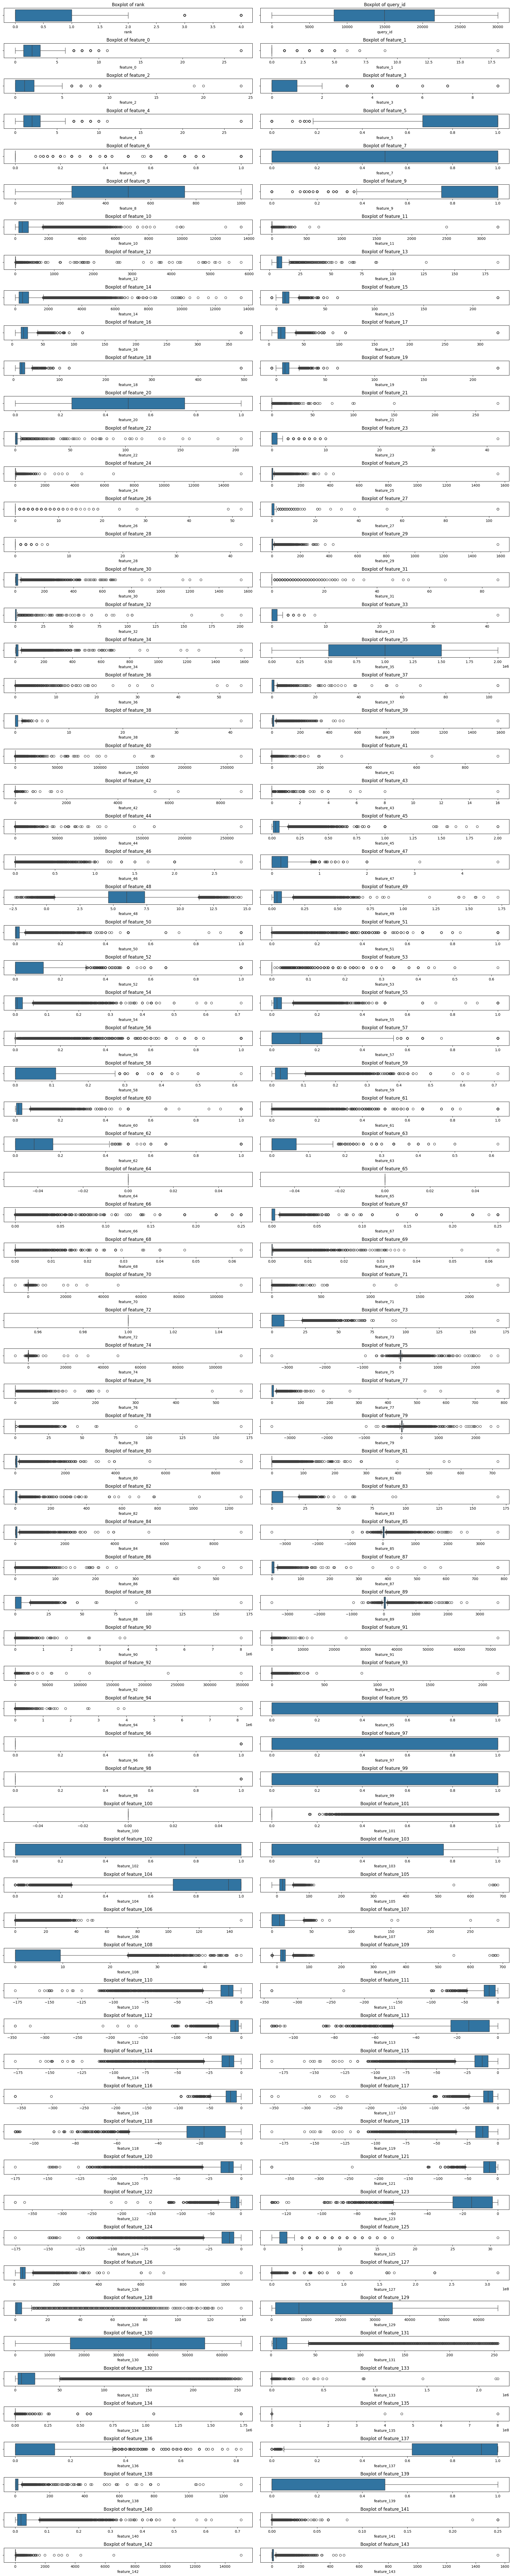

In [19]:
plot_boxplots(df_train)

Use z-score normalization for features_0 - feature_143

Используем стандартизацию для признаков feature_0 - feature_143

In [20]:
def normalize_data(x, standard_scaler=None):
    cols = x.columns[1:]
    
    if standard_scaler is None:
        standard_scaler = StandardScaler()
        standard_scaler.fit(x[cols])
    x[cols] = standard_scaler.transform(x[cols])

    return x, standard_scaler

To train XGBRanker create `qid` feature and sort the values, then split the dataset into x and y and apply normalisation

Для работы XGBRanker создаем признак `qid` и сортируем значения, затем разделяем выборку на x и y и применяем нормализацию

In [21]:
def prepare_data(df, standard_scaler=None):
    df = df.rename(columns={'query_id': 'qid'})
    df = df.sort_values(by='qid')

    x = df.drop(columns=['rank'])
    y = df['rank']
    
    x, standard_scaler = normalize_data(x, standard_scaler)
    
    return x, y, standard_scaler

Apply the changes to all 3 datasets

Применяем изменения ко всем 3 выборкам

In [22]:
X_train, y_train, standard_scaler = prepare_data(df_train)

In [23]:
X_val, y_val, _ = prepare_data(df_val, standard_scaler=standard_scaler)

In [24]:
X_test, y_test, _ = prepare_data(df_test, standard_scaler=standard_scaler)

In [25]:
X_train.head()

,qid,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
83,10,0.880657,-0.357494,1.743768,-0.694420,0.865138,0.576319,-0.368117,1.090624,-1.732250,...,-0.023432,-0.00472,-0.697331,0.729460,0.473799,-0.717889,-0.449289,-0.120124,-0.217947,-0.434790
52,10,0.880657,4.804618,1.743768,3.096717,0.865138,0.576319,3.384353,1.090624,-1.732706,...,-0.023432,-0.00472,3.027836,0.673079,0.473799,1.832998,0.192837,-0.090915,0.716780,0.803489
49,10,0.880657,-0.357494,-1.147909,-0.694420,0.865138,0.576319,-0.368117,-1.290154,-1.732750,...,-0.023432,-0.00472,-0.697331,0.702593,-0.734520,-0.717889,-0.456697,-0.116079,-0.235583,-0.458153
23,10,0.880657,-0.357494,1.743768,-0.694420,0.865138,0.576319,-0.368117,1.090624,-1.733133,...,-0.023432,-0.00472,-0.697331,0.727179,0.473799,-0.717889,-0.173760,-0.119674,-0.112129,-0.294607
35,10,0.880657,-0.357494,-0.184016,0.569292,0.865138,0.576319,-0.368117,-0.496562,-1.732956,...,-0.023432,-0.00472,0.406421,0.507521,-0.161159,0.132406,-0.179181,-0.010030,0.152417,0.055849


Save processed datasets

Сохраняем обработанные выборки

In [26]:
X_train.to_csv("data/X_train.csv", index=False)
X_val.to_csv("data/X_val.csv", index=False)
X_test.to_csv("data/X_test.csv", index=False)

y_train.to_csv("data/y_train.csv", index=False)
y_val.to_csv("data/y_val.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)

In [27]:
X_train = pd.read_csv("data/X_train.csv")
X_val = pd.read_csv("data/X_val.csv")
X_test = pd.read_csv("data/X_test.csv")

y_train = pd.read_csv("data/y_train.csv")
y_val = pd.read_csv("data/y_val.csv")
y_test = pd.read_csv("data/y_test.csv")

# Modeling

## Train

XGBRanker was used as the model with a maximum number of 200 estimators and an early stop of 20.

В качестве модели был использовал XGBRanker с максимальным числом деревьев - 200 и ранней остановкой - 20.

In [28]:
model = XGBRanker(
    objective='rank:ndcg', 
    n_estimators=200,
    verbosity=1, 
    early_stopping_rounds=20,
    random_state=seed
)

To train the model pass the training and validation datasets

Для обучения модели передаем обучающую и валидационную выборки

In [29]:
model.fit(
    X_train, 
    y_train,  
    eval_set=[(X_val, y_val)],
    verbose=True)

[0]	validation_0-ndcg@32:0.72798
[1]	validation_0-ndcg@32:0.73702
[2]	validation_0-ndcg@32:0.74290
[3]	validation_0-ndcg@32:0.74480
[4]	validation_0-ndcg@32:0.74682
[5]	validation_0-ndcg@32:0.74940
[6]	validation_0-ndcg@32:0.75177
[7]	validation_0-ndcg@32:0.75165
[8]	validation_0-ndcg@32:0.75209
[9]	validation_0-ndcg@32:0.75433
[10]	validation_0-ndcg@32:0.75513
[11]	validation_0-ndcg@32:0.75650
[12]	validation_0-ndcg@32:0.75646
[13]	validation_0-ndcg@32:0.75768
[14]	validation_0-ndcg@32:0.75913
[15]	validation_0-ndcg@32:0.75997
[16]	validation_0-ndcg@32:0.75885
[17]	validation_0-ndcg@32:0.76036
[18]	validation_0-ndcg@32:0.76126
[19]	validation_0-ndcg@32:0.76222
[20]	validation_0-ndcg@32:0.76307
[21]	validation_0-ndcg@32:0.76387
[22]	validation_0-ndcg@32:0.76339
[23]	validation_0-ndcg@32:0.76427
[24]	validation_0-ndcg@32:0.76496
[25]	validation_0-ndcg@32:0.76507
[26]	validation_0-ndcg@32:0.76617
[27]	validation_0-ndcg@32:0.76730
[28]	validation_0-ndcg@32:0.76731
[29]	validation_0-ndcg@3

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=20, enable_categorical=False, eval_metric=None,
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, random_state=1234, ...)

Save the trained model to a JSON file

Сохраняем обученную модель в JSON файл

In [30]:
model.save_model('model.json')

## Test

Use the test dataset to evaluate the quality of the trained model

Используем тестовую выборку для оценки качетсва обученной модели

In [31]:
y_pred = model.predict(X_test)

### Metrics

#### NDCG@k

In [32]:
def ndcg_at_k(y_true, y_score, qid, k=10):
    """
    Calculates Normalized Discounted Cumulative Gain (NDCG@k)
    for given true relevancies, predicted scores, and query IDs.

    Args:
        y_true (List[int]): List of true relevancies (0 or 1)
        y_score (List[float]): List of predicted relevance scores
        qid (List[int]): List of query identifiers
        k (int, optional): Number of top results to consider. Default is 10.

    Returns:
        float: The NDCG@k value, averaged across all queries
    """
    queries = sorted(set(qid))  # Unique query identifiers
    ndcg_scores = []

    for q in queries:
        q_mask = np.array(qid) == q  # Mask for the current query
        q_y_true = np.array(y_true)[q_mask]  # True relevancies for the query
        q_y_score = np.array(y_score)[q_mask]  # Predicted scores for the query

        # Sort by descending predicted scores
        sort_idx = np.argsort(-q_y_score)
        q_y_true = q_y_true[sort_idx]
        q_y_score = q_y_score[sort_idx]

        # Skip queries with only one document
        if len(q_y_true) <= 1:
            continue

        # Calculate NDCG@k using ndcg_score
        ndcg = ndcg_score([q_y_true.flatten()], [q_y_score], k=k)
        ndcg_scores.append(ndcg)

    if not ndcg_scores:
        return 0.0  # If all queries have only one document
    else:
        return np.mean(ndcg_scores)


In [33]:
print(f"NDCG@5: {ndcg_at_k(y_test, y_pred, X_test['qid'], k=5)}")

NDCG@5: 0.5785061518974165


In [34]:
print(f"NDCG@10: {ndcg_at_k(y_test, y_pred, X_test['qid'], k=10)}")

NDCG@10: 0.636932431845968


#### MRR

In [35]:
def mean_reciprocal_rank(y_true, y_score, qid):
    """
    Computes the Mean Reciprocal Rank (MRR) for the given true relevances, predicted scores, and query IDs.

    Args:
        y_true (List[int]): List of true relevances (0 or 1)
        y_score (List[float]): List of predicted relevance scores
        qid (List[int]): List of query IDs

    Returns:
        float: The MRR value, averaged across all queries
    """
    queries = sorted(set(qid))  # Unique query IDs
    rr_scores = []

    for q in queries:
        q_mask = np.array(qid) == q  # Mask for the current query
        q_y_true = np.array(y_true)[q_mask]  # True relevances for the query
        q_y_score = np.array(y_score)[q_mask]  # Predicted scores for the query

        # Sort by descending predicted scores
        sort_idx = np.argsort(-q_y_score)
        q_y_true = q_y_true[sort_idx]

        # Find the rank of the first relevant document
        first_relevant = np.where(q_y_true == 1)[0]
        if first_relevant.size > 0:
            rank = first_relevant[0] + 1  # Rank starts from 1
            rr = 1.0 / rank
        else:
            rr = 0.0  # No relevant documents

        rr_scores.append(rr)

    return np.mean(rr_scores)

In [36]:
print(f"MRR: {mean_reciprocal_rank(y_test, y_pred, X_test['qid'])}")

MRR: 0.4732963511681146


#### MAP

In [37]:
def mean_average_precision(y_true, y_score, qid):
    """
    Computes the Mean Average Precision (MAP) for the given true relevances, predicted scores, and query IDs.

    Args:
        y_true (List[int]): List of true relevances (0 or 1)
        y_score (List[float]): List of predicted relevance scores
        qid (List[int]): List of query IDs

    Returns:
        float: The MAP value, averaged across all queries
    """
    queries = sorted(set(qid))  # Unique query IDs
    avg_prec_scores = []

    for q in queries:
        q_mask = np.array(qid) == q  # Mask for the current query
        q_y_true = np.array(y_true)[q_mask]  # True relevances for the query
        q_y_score = np.array(y_score)[q_mask]  # Predicted scores for the query

        # Sort by descending predicted scores
        sort_idx = np.argsort(-q_y_score)
        q_y_true = q_y_true[sort_idx]

        # Calculate Average Precision (AP)
        precisions = []
        num_relevant = np.sum(q_y_true)
        if num_relevant > 0:
            tp = 0
            for rank, rel in enumerate(q_y_true, start=1):
                if rel:
                    tp += 1
                    precision = tp / rank
                    precisions.append(precision)
            ap = np.mean(precisions)
        else:
            ap = 0.0  # No relevant documents

        avg_prec_scores.append(ap)

    return np.mean(avg_prec_scores)

In [38]:
print(f"MAP: {mean_average_precision(y_test, y_pred, X_test['qid'])}")

MAP: 0.6470681246389813
